# S-Learner: Uplift Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.datasets import fetch_x5
from feature_extraction import UpliftFeatureExtractor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklift.metrics import uplift_at_k, uplift_auc_score

In [2]:
dataset = fetch_x5()
data = dataset.data

In [3]:
# подсчет фич
extractor = UpliftFeatureExtractor(drop_redundant=True)
df = extractor.calculate_features(
    clients_df=data.clients,
    train_df=data.train,
    treatment_df=dataset.treatment,
    target_df=dataset.target,
    purchases_df=data.purchases
)

features = extractor.feature_names

print(f"Создано признаков: {len(features)}")
print(f"Размер датафрейма: {df.shape}")
print(f"Признаки: {features}")

Создано признаков: 32
Размер датафрейма: (200039, 34)
Признаки: ['first_issue_month', 'first_issue_weekday', 'first_issue_year_quarter_idx', 'total_transactions', 'avg_transaction_amount', 'max_transaction_amount', 'min_transaction_amount', 'total_express_points_received', 'total_express_points_spent', 'avg_express_points_per_transaction', 'points_earned_to_spent_ratio', 'unique_products_count', 'avg_product_quantity', 'transaction_period_days', 'first_transaction_quarter', 'first_transaction_year_quarter_idx', 'unique_stores_visited', 'store_loyalty_ratio', 'avg_purchase_per_day', 'transactions_per_month', 'points_spend_ratio', 'points_balance_ratio', 'unique_store_intensity', 'log_total_purchase_sum', 'seasonal_quarter_code', 'avg_items_per_transaction', 'spend_points_per_transaction', 'transaction_value_density', 'is_super_loyal', 'age', 'gender', 'is_activated']


In [4]:
df.isna().sum()

first_issue_month                     0
first_issue_weekday                   0
first_issue_year_quarter_idx          0
total_transactions                    0
avg_transaction_amount                0
max_transaction_amount                0
min_transaction_amount                0
total_express_points_received         0
total_express_points_spent            0
avg_express_points_per_transaction    0
points_earned_to_spent_ratio          0
unique_products_count                 0
avg_product_quantity                  0
transaction_period_days               0
first_transaction_quarter             0
first_transaction_year_quarter_idx    0
unique_stores_visited                 0
store_loyalty_ratio                   0
avg_purchase_per_day                  0
transactions_per_month                0
points_spend_ratio                    0
points_balance_ratio                  0
unique_store_intensity                0
log_total_purchase_sum                0
seasonal_quarter_code                 0


In [5]:
# добавление тритмента как признак
X_slearner = df[features].copy()
X_slearner['treatment'] = df['treatment_flg'].astype(int)
y = df["target"]

# определение категориальных признаков
categorical_features = []
for col in X_slearner.columns:
    if X_slearner[col].dtype.name == "category" or (X_slearner[col].dtype == "object" and X_slearner[col].nunique() < 100):
        categorical_features.append(col)

if 'treatment' not in categorical_features:
    categorical_features.append('treatment')
    
cat_features_indices = [i for i, col in enumerate(X_slearner.columns) if col in categorical_features]

# разделение на трейн/тест
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X_slearner, y, df['treatment_flg'], 
    test_size=0.2, random_state=67, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (160031, 33)
Размер тестовой выборки: (40008, 33)


In [6]:
# обучение S-Learner модели
slearner_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    eval_metric="AUC",
    verbose=100,
    use_best_model=True,
    random_state=67
)

slearner_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features_indices
)

Learning rate set to 0.111006
0:	test: 0.7529327	best: 0.7529327 (0)	total: 204ms	remaining: 3m 24s
100:	test: 0.7686754	best: 0.7686754 (100)	total: 5.9s	remaining: 52.5s
200:	test: 0.7687562	best: 0.7689688 (157)	total: 11.5s	remaining: 45.6s
300:	test: 0.7685436	best: 0.7689688 (157)	total: 17.1s	remaining: 39.7s
400:	test: 0.7681993	best: 0.7689688 (157)	total: 22.7s	remaining: 34s
500:	test: 0.7679057	best: 0.7689688 (157)	total: 28.3s	remaining: 28.2s
600:	test: 0.7675273	best: 0.7689688 (157)	total: 34s	remaining: 22.6s
700:	test: 0.7671972	best: 0.7689688 (157)	total: 39.5s	remaining: 16.9s
800:	test: 0.7668492	best: 0.7689688 (157)	total: 45.2s	remaining: 11.2s
900:	test: 0.7665723	best: 0.7689688 (157)	total: 50.7s	remaining: 5.57s
999:	test: 0.7661453	best: 0.7689688 (157)	total: 56.2s	remaining: 0us

bestTest = 0.7689688304
bestIteration = 157

Shrink model to first 158 iterations.


In [7]:
# предикты для тестовой выборки:
X_test_treatment = X_test.copy()
X_test_treatment['treatment'] = 1

X_test_control = X_test.copy()
X_test_control['treatment'] = 0

prob_treatment = slearner_model.predict_proba(X_test_treatment)[:, 1]
prob_control = slearner_model.predict_proba(X_test_control)[:, 1]

# uplift = P(Y=1|T=1) - P(Y=1|T=0)
uplift_scores = prob_treatment - prob_control

print(f"Размер предсказаний: {len(uplift_scores)}")
print(f"Min uplift: {uplift_scores.min():.4f}")
print(f"Max uplift: {uplift_scores.max():.4f}")
print(f"Mean uplift: {uplift_scores.mean():.4f}")

Размер предсказаний: 40008
Min uplift: -0.0989
Max uplift: 0.3636
Mean uplift: 0.0298


In [8]:
# расчет метрик uplift
uplift_10 = uplift_at_k(y_true=y_test, uplift=uplift_scores, treatment=treatment_test, k=0.1, strategy='overall')
uplift_20 = uplift_at_k(y_true=y_test, uplift=uplift_scores, treatment=treatment_test, k=0.2, strategy='overall')
uplift_30 = uplift_at_k(y_true=y_test, uplift=uplift_scores, treatment=treatment_test, k=0.3, strategy='overall')
auuc_score = uplift_auc_score(y_true=y_test, uplift=uplift_scores, treatment=treatment_test)

print(f"Uplift@10%: {uplift_10:.4f}")
print(f"Uplift@20%: {uplift_20:.4f}")
print(f"Uplift@30%: {uplift_30:.4f}")
print(f"AUUC: {auuc_score:.4f}")

Uplift@10%: 0.1109
Uplift@20%: 0.0895
Uplift@30%: 0.0685
AUUC: 0.0231


In [9]:
# важность признаков в S-Learner
slearner_features = list(features) + ['treatment']
feature_importance_df = pd.DataFrame({
    'feature': slearner_features,
    'importance': slearner_model.get_feature_importance()
}).sort_values('importance', ascending=False)

feature_importance_df.head(10)

,feature,importance
3,total_transactions,28.956584
13,transaction_period_days,14.767688
19,transactions_per_month,14.625088
2,first_issue_year_quarter_idx,3.717843
31,is_activated,3.278376
22,unique_store_intensity,3.255220
29,age,2.938613
5,max_transaction_amount,2.457213
32,treatment,2.231338
0,first_issue_month,2.074002


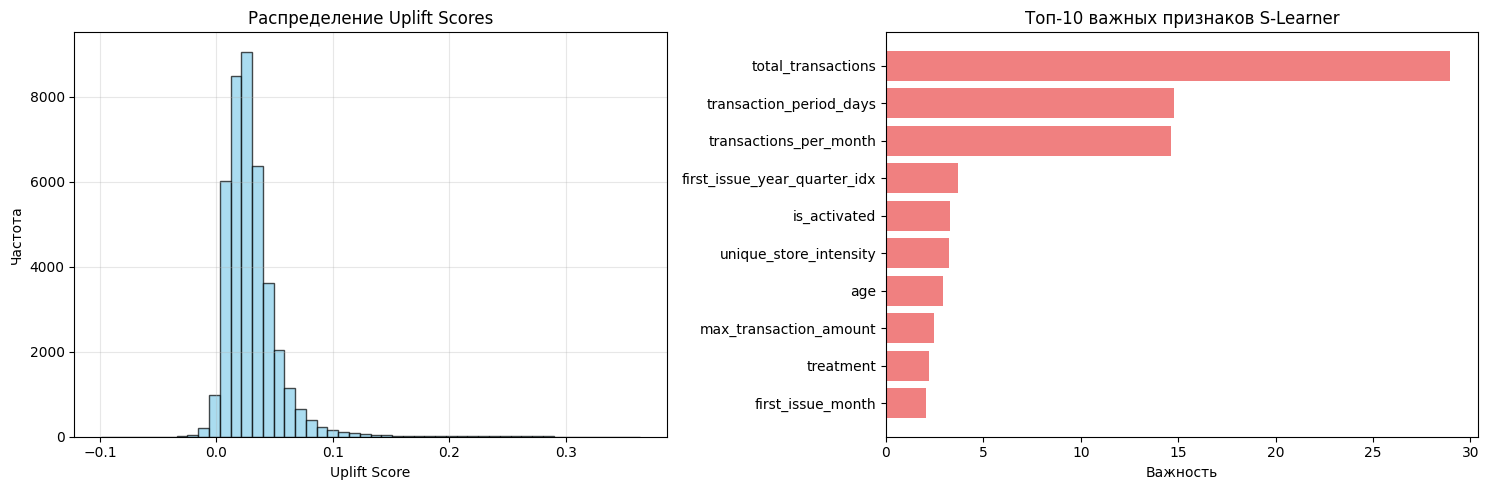

In [10]:
# визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# распределение uplift scores
axes[0].hist(uplift_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение Uplift Scores')
axes[0].set_xlabel('Uplift Score')
axes[0].set_ylabel('Частота')
axes[0].grid(True, alpha=0.3)

# 10 важных признаков
top_features = feature_importance_df.head(10)
axes[1].barh(top_features['feature'], top_features['importance'], color='lightcoral')
axes[1].set_title('Топ-10 важных признаков S-Learner')
axes[1].set_xlabel('Важность')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()